# Project: Trashformer

#### Description: The backend code for "Trashformer" serves as the core engine for an innovative application designed to assist users in identifying recyclable objects and suggesting reuse or recycling methods.

Key Features:

- Object Detection: Utilizes YOLOv3 to detect items such as plastic bottles, cans, and other recyclable materials from the images taken by the user.
- Image Processing: Processes the image using OpenCV to create detection blobs, which are passed through a neural network for item recognition.
- Reuse and Recycling Suggestions: Once an object is detected, the app suggests creative reuse ideas and recycling instructions from a pre-defined database or queries an AI API for additional recommendations.
- AI-powered Recycling Instructions: If a detected item is not found in the local database, the app queries an external AI API for recycling and reuse suggestions.
- Customizable: The detection threshold and item categories can be expanded to accommodate more types of waste or region-specific recycling guidelines.

In [2]:
# Dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import requests
import json
from PIL import Image

# Load YOLO model and class labels
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]
    
# Set the API key
ARLIAI_API_KEY = "86de0acd-f653-41ab-a1c2-d53efed6ee3f"

YOLOv3 Weights:
https://pjreddie.com/media/files/yolov3.weights

YOLOv3 Config:
https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg

COCO Class Names:
https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names

OpenCV Library: 
https://github.com/opencv/opencv/tree/4.10.0

In [3]:
# Database of alternate uses and recycling instructions (Can be edited to suit guidelines and add/remove items)
reusable_items = [
    {"Name": "Plastic Bottle", "Reuse Ideas": "Cut and use as planters, or make DIY storage containers.", "Recycling Instructions": "Rinse and place in the recycling bin."},
    {"Name": "Glass Jar", "Reuse Ideas": "Reuse as storage jars for spices, screws, or craft supplies.", "Recycling Instructions": "Rinse thoroughly, remove the lid, and recycle."},
    {"Name": "Aluminum Can", "Reuse Ideas": "Use for small planters, pen holders, or candle molds.", "Recycling Instructions": "Rinse, crush if possible, and recycle."},
    {"Name": "Cardboard Box", "Reuse Ideas": "Cut and use for DIY drawer dividers or kids' craft projects.", "Recycling Instructions": "Flatten and recycle in the paper recycling bin."},
    {"Name": "Milk Carton", "Reuse Ideas": "Use as small planters or bird feeders with some DIY cutting.", "Recycling Instructions": "Rinse and recycle if facilities accept cartons."},
    {"Name": "Plastic Cutlery", "Reuse Ideas": "Clean and reuse for picnics or craft projects.", "Recycling Instructions": "Recycle if facilities accept it; otherwise, dispose of as waste."},
    {"Name": "Toilet Paper Roll", "Reuse Ideas": "Use for cord organizers, seed starters, or crafts.", "Recycling Instructions": "Recycle in the paper bin."},
    {"Name": "Shoe Box", "Reuse Ideas": "Reuse as storage for small items, cable organizers, or crafts.", "Recycling Instructions": "Recycle in paper bin if clean and free of adhesives."},
    {"Name": "Glass Bottle", "Reuse Ideas": "Use as a vase, DIY lamp, or decorative centerpiece.", "Recycling Instructions": "Rinse and recycle in glass bin."},
    {"Name": "Paper", "Reuse Ideas": "Use for origami, scrapbooking, or as wrapping paper.", "Recycling Instructions": "Place in the paper recycling bin."},
    {"Name": "Tin Can", "Reuse Ideas": "Use as a pen holder, plant pot, or for DIY lanterns.", "Recycling Instructions": "Rinse, remove the lid, and place in metal recycling."},
    {"Name": "Old T-shirt", "Reuse Ideas": "Turn into cleaning rags, reusable bags, or use for craft projects.", "Recycling Instructions": "Donate if in good condition or recycle at textile centers."},
    {"Name": "Egg Carton", "Reuse Ideas": "Use as seed starters, paint trays, or for kids' crafts.", "Recycling Instructions": "Recycle paper cartons in the paper bin, dispose of foam responsibly."},
    {"Name": "Metal Hanger", "Reuse Ideas": "Use to organize scarves, belts, or for craft wire projects.", "Recycling Instructions": "Return to dry cleaners for reuse, or recycle as scrap metal."},
    {"Name": "Newspaper", "Reuse Ideas": "Use for packing material, garden mulch, or gift wrapping.", "Recycling Instructions": "Recycle in paper bin or use in compost."},
    {"Name": "Cereal Box", "Reuse Ideas": "Use for drawer organizers, or cut into bookmarks or postcards.", "Recycling Instructions": "Flatten and place in the paper recycling bin."},
    {"Name": "Old Magazines", "Reuse Ideas": "Use for collages, vision boards, or wrapping gifts.", "Recycling Instructions": "Recycle in paper bin."},
    {"Name": "Bubble Wrap", "Reuse Ideas": "Reuse for packaging, or as insulation material for plants in winter.", "Recycling Instructions": "Recycle at plastic bag recycling points (often found at grocery stores)."},
    {"Name": "Batteries", "Reuse Ideas": "Rechargeable batteries can be reused multiple times.", "Recycling Instructions": "Dispose of at designated battery recycling centers or e-waste facilities."},
    {"Name": "Electronics (e.g., old phones, laptops)", "Reuse Ideas": "Repurpose as media storage devices or donate for reuse.", "Recycling Instructions": "Recycle at e-waste centers or return to manufacturers with recycling programs."},
    {"Name": "Light Bulbs (CFLs or LEDs)", "Reuse Ideas": "Some light bulbs can be repurposed for craft projects like ornaments or plant holders.", "Recycling Instructions": "Recycle at designated recycling points (especially for CFLs due to mercury content)."},
    {"Name": "Printer Cartridges", "Reuse Ideas": "Refill and reuse at designated refill stations.", "Recycling Instructions": "Recycle through manufacturer take-back programs or e-waste facilities."},
    {"Name": "Old CDs/DVDs", "Reuse Ideas": "Use for DIY crafts like coasters or wall art.", "Recycling Instructions": "Recycle at specialized electronic recycling centers."},
    {"Name": "Styrofoam (Polystyrene)", "Reuse Ideas": "Use as insulation material for DIY projects or packaging.", "Recycling Instructions": "Check with local recycling centers, as many do not accept styrofoam. Go to designated styrofoam deposit spots if available."},
    {"Name": "Plastic Bags", "Reuse Ideas": "Reuse for storage or packing, or as trash bin liners.", "Recycling Instructions": "Recycle at designated plastic bag recycling points (often found at grocery stores)."},
    {"Name": "Old Tires", "Reuse Ideas": "Repurpose for DIY garden planters, playground equipment, or tire swings.", "Recycling Instructions": "Recycle at tire recycling facilities or return to tire retailers for disposal."},
    {"Name": "Fabric Scraps", "Reuse Ideas": "Use for quilting, crafts, or stuffing pillows.", "Recycling Instructions": "Donate to textile recycling centers or creative reuse centers."},
    {"Name": "Plastic Food Containers", "Reuse Ideas": "Reuse for food storage or DIY organizers.", "Recycling Instructions": "Clean and recycle if facilities accept the type of plastic (usually #1 or #2)."},
    {"Name": "Clothing (worn or damaged)", "Reuse Ideas": "Repurpose into cleaning rags, patchwork, or insulation materials.", "Recycling Instructions": "Donate if usable, or recycle at textile recycling centers."},
]

# Convert the list of dictionaries into a DataFrame
df_reusable_items = pd.DataFrame(reusable_items)

# Display first 5 rows
df_reusable_items.head()

,Name,Reuse Ideas,Recycling Instructions
0,Plastic Bottle,"Cut and use as planters, or make DIY storage c...",Rinse and place in the recycling bin.
1,Glass Jar,"Reuse as storage jars for spices, screws, or c...","Rinse thoroughly, remove the lid, and recycle."
2,Aluminum Can,"Use for small planters, pen holders, or candle...","Rinse, crush if possible, and recycle."
3,Cardboard Box,Cut and use for DIY drawer dividers or kids' c...,Flatten and recycle in the paper recycling bin.
4,Milk Carton,Use as small planters or bird feeders with som...,Rinse and recycle if facilities accept cartons.


Image loaded successfully
Detected item: bottle: 0.99


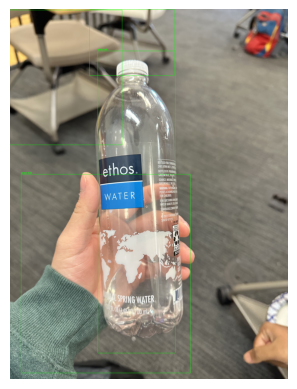

Item: Plastic Bottle
Reuse Ideas: Cut and use as planters, or make DIY storage containers.
Recycling Instructions: Rinse and place in the recycling bin.



In [4]:
# For the demo, this will determine the images that are being detected.
while True:
    try:
        test_number = int(input("Enter image number (1-4): "))
        if 1 <= test_number <= 4:
            break
        else:
            print("Error: Please enter a number between 1 and 4.")
    except ValueError:
        print("Error: Invalid input. Please enter a number between 1 and 4.")
if test_number == 1:
    image_path = ("Test1.jpg")
elif test_number == 2:
    image_path = ("Test2.jpg")
elif test_number == 3:
    image_path = ("Test3.jpg")
else:
    image_path = ("Test4.jpg")

# Initialize variables
boxes = []
confidences = []
class_ids = []
detected_items = [] 
output_text = ""
item_detected = False
item_found = False

# Function to get recycling suggestion from ARLIAI API
def get_recycling_suggestion(item_name):
    url = "https://api.arliai.com/v1/chat/completions"

    # Create the payload for the API request
    payload = json.dumps({
        "model": "Meta-Llama-3.1-8B-Instruct",
        "messages": [
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": f"Give a one-sentence recycling instruction for a {item_name} and also provide a one-sentence reusing instruction if applicable, food items should not be reused. Put these into separate sentences. Limit each sentence to 20 words at most."}
        ],
        "repetition_penalty": 1.1,
        "temperature": 0.7,
        "top_p": 0.9,
        "top_k": 40,
        "max_tokens": 1024,
        "stream": False
    })

    headers = {
        'Content-Type': 'application/json',
        'Authorization': f"Bearer {ARLIAI_API_KEY}"
    }

    # Make the POST request
    response = requests.post(url, headers=headers, data=payload)

    # Check for a successful response
    if response.status_code == 200:
        # Parse the response and extract the assistant's reply
        response_data = response.json()
        suggestion = response_data['choices'][0]['message']['content']
        return suggestion.strip()
    else:
        print(f"Error: {response.status_code}, {response.text}")
        return "Could not get recycling instructions."
    
# Load an image
image = cv2.imread(image_path)
if image is None:
    print("Error: Image not found or unable to load")
else:
    print("Image loaded successfully")
    height, width = image.shape[:2]

    # Create a blob from the image
    blob = cv2.dnn.blobFromImage(image, scalefactor=1/255.0, size=(416, 416), swapRB=True, crop=False)
    net.setInput(blob)

    # Get the output layer names
    output_layer_indices = net.getUnconnectedOutLayers()
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in output_layer_indices]

    # Run forward pass and get the detections
    outputs = net.forward(output_layers)

    # Loop over each detection
    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            # Filter out weak detections
            if confidence > 0.5:
                # YOLO outputs center (x, y) of bounding box, and width, height
                box = detection[:4] * np.array([width, height, width, height])
                center_x, center_y, box_w, box_h = box.astype("int")

                # Calculate the top-left corner of the bounding box
                x = int(center_x - (box_w / 2))
                y = int(center_y - (box_h / 2))

                # Append to lists
                boxes.append([x, y, int(box_w), int(box_h)])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Apply non-maxima suppression to remove overlapping boxes
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    # Draw the boxes and labels on the image and collect detected items
    if len(indices) > 0:
        for i in indices.flatten():
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            confidence = confidences[i]

            # Append detected items to the list
            detected_items.append(f"{label}: {confidence:.2f}")

            # Draw the bounding box
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(image, f"{label} {confidence:.2f}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Output the highest confidence detected item
    if detected_items:
        print(f"Detected item: {detected_items[0]}")
        item_detected = True
    else:
        print("No items detected.")

    # Show the image with the detections
    import matplotlib.pyplot as plt
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Hide axes
    plt.show()

if item_detected:

    # Clean the confidence score from the detected object
    cleaned_item = detected_items[0].split(':')[0].strip()
    # Export to save detected item data 
    with open('Detected_Items.txt', 'a') as file: 
        file.write(f"{cleaned_item}\n")

    # Loop through each item in the reusable_items list
    for index, row in df_reusable_items.iterrows():
        if cleaned_item.lower() in row["Name"].lower():
            output_text += f"Item: {row['Name']}\n"
            output_text += f"Reuse Ideas: {row['Reuse Ideas']}\n"
            output_text += f"Recycling Instructions: {row['Recycling Instructions']}\n"
            item_found = True
            break

    # If item was not found in the database, use AI to get suggestions
    if not item_found:
        suggestion = get_recycling_suggestion(cleaned_item)
        output_text += f"Detected item: {cleaned_item.capitalize()} (AI response may be inaccurate)\n"
        output_text += suggestion + "\n"

if not item_detected:
    output_text = "We were unable to find an object in your image. Here are some general recycling instructions: \n - Recycle bottles, cans, paper, and cardboard. \n - Keep food and liquids out of recyclables. \n - No loose plastic bags or bagged recyclables. \n Always check local programs for specific recycling guidelines."

print(output_text)
# Export the results to a .txt file
with open(r"Output.txt", "w") as file:
    file.write(output_text)